# Categorical GPLVM
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\ddt}[1]{\dfrac{d #1}{ dt}}$

Trying to implement the model in [this paper](https://arxiv.org/pdf/1503.02182.pdf)

But first, a GP Classifier to learn how to workwith a categorical likelihood

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import os
from sklearn.utils import shuffle
import sklearn.datasets as datasets
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from torch.nn import Parameter
import pyro.ops.stats as stats
from sklearn.manifold import Isomap
from tqdm import trange

def plot2dproj(X,labels,method=None, legend=False):
    for i in range(np.unique(labels).shape[0]):
        pts = X[labels==i]
        plt.scatter(pts[:,0],pts[:,1], s=3., label=str(i))
    if method is not None:
        plt.title( method+" Embedding",fontsize=16)
    if legend: plt.legend()
    plt.show()
    
def test_binary(gpmodel, X_test, Y_test,cuda):
    if isinstance(gpmodel.likelihood, gp.likelihoods.Binary):
        with torch.no_grad():
            if cuda:
                X_test, Y_test = X_test.cuda(), Y_test.cuda()
            f_loc, f_var = gpmodel(X_test)
            pred = gpmodel.likelihood(f_loc,f_var)
            return (100.*pred.eq(Y_test.t()).detach().cpu().sum()/Y_test.nelement()).item()
        
def plot_before_after(Xi, Xf, Xui, Xuf, labels,method=None, legend=False):
    fig, ax = plt.subplots(1,2,figsize=(18,6))
    fig.suptitle(r"Data Points and VSGP Inducing Points",fontsize=16)
    ax[0].set_title(r"Initial",fontsize=16)
    ax[1].set_title(r"Final",fontsize=16)
    for i in range(np.unique(labels).shape[0]):
        pts_i = Xi[labels==i]
        pts_f = Xf[labels==i]
        ax[0].scatter(pts_i[:,0],pts_i[:,1], s=3., label=str(i))
        ax[1].scatter(pts_f[:,0],pts_f[:,1], s=3., label=str(i))
    ax[0].scatter(Xui[:,0],Xui[:,1], marker='x', color='k', label='Inducing')
    ax[1].scatter(Xuf[:,0],Xuf[:,1], marker='x', color='k', label='Inducing')
    if legend: ax[0].legend()

In [2]:
n_train = 5000
xor_pts = 2*np.random.rand(n_train,2) - 1

In [3]:
xor_y = (xor_pts[:,0]*xor_pts[:,1]>0).astype(np.float)
xor_pts = xor_pts + 0.1*np.random.randn(n_train,2)

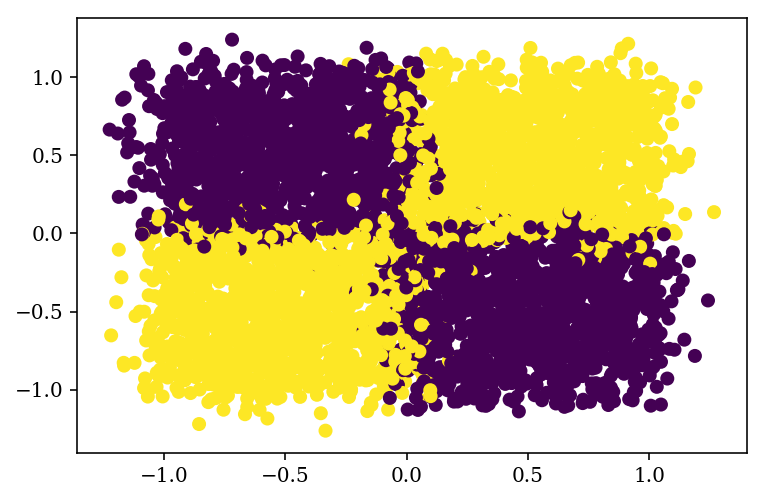

In [4]:
plt.scatter(xor_pts[:,0],xor_pts[:,1],c=xor_y)
plt.show()

In [5]:
X_xor = torch.tensor(xor_pts,dtype=torch.get_default_dtype())
Y_xor = torch.tensor(xor_y,dtype=torch.get_default_dtype())
latent_dim = 2
rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X_xor.max(0)[0] - X_xor.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X_xor.max(0)[0] - X_xor.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X_xor.max(0)[0] - X_xor.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X_xor.max(0)[0] - X_xor.mean(0))
classifier_K = rbf
classifier_K = gp.kernels.Sum(classifier_K,m52)
binary_likelihood = gp.likelihoods.Binary()
#gpc = gp.models.VariationalGP(X_xor, Y_xor,kernel=classifier_K,likelihood=binary_likelihood,jitter=1e-3, whiten=True ) 
#cuda_gpc = gpc.cuda()

In [6]:
loss_fn = pyro.infer.TraceGraph_ELBO().differentiable_loss

In [108]:
optimizer = torch.optim.Adam(cuda_gpc.parameters(), lr=0.01)
losses = []
num_steps = 1000
for i in trange(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(cuda_gpc.model, cuda_gpc.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 1000/1000 [00:15<00:00, 64.09it/s]


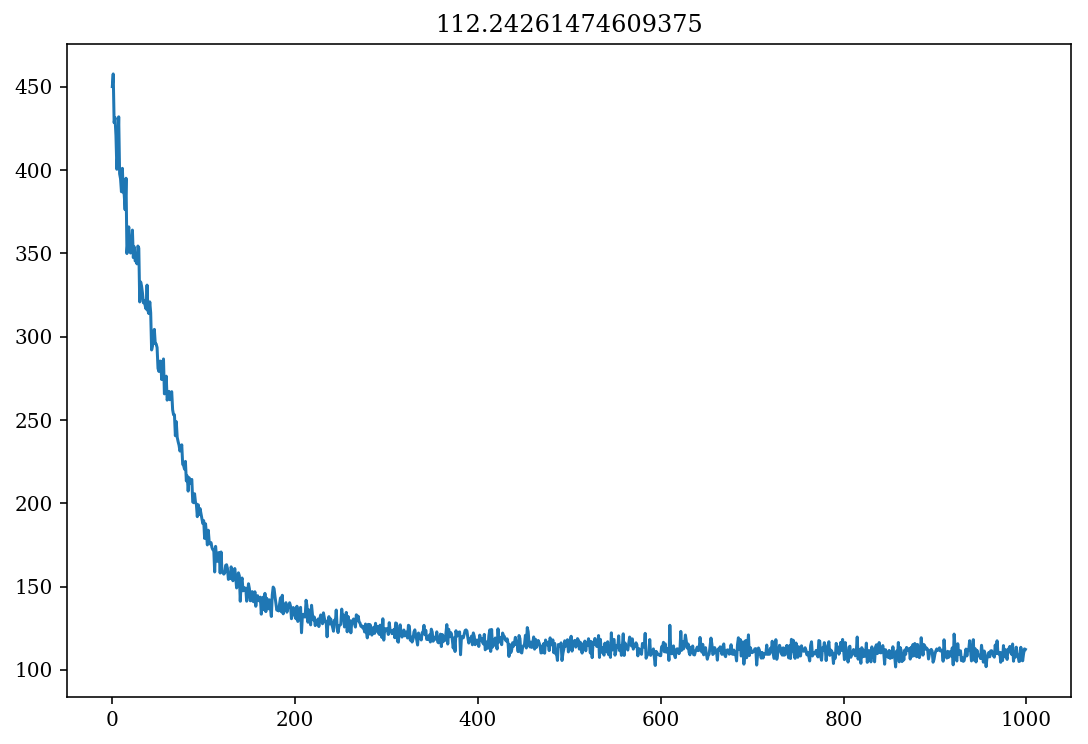

In [109]:
plt.plot(losses)
plt.title(losses[-1])
plt.show()

In [6]:
n_test = 100
xor_test_np = 2*np.random.rand(n_test,2) - 1
xor_test = torch.tensor(xor_test_np, dtype=torch.get_default_dtype())
xor_test_true = ((xor_test[:,0]*xor_test[:,1])>0)*1.

In [7]:
Xu = 2*torch.rand((20,2)) - 1

In [12]:
vsgp_xor = gp.models.VariationalSparseGP(X=X_xor, y=Y_xor ,kernel=classifier_K, Xu=Xu, likelihood=binary_likelihood,                                    jitter=1e-3, whiten=True, num_data = X_xor.shape[0])
vsgp_xor = vsgp_xor.cuda()
vsgp_xor.X = vsgp_xor.X.cuda()
vsgp_xor.y = vsgp_xor.y.cuda()

In [13]:
losses = gp.util.train(vsgp_xor)

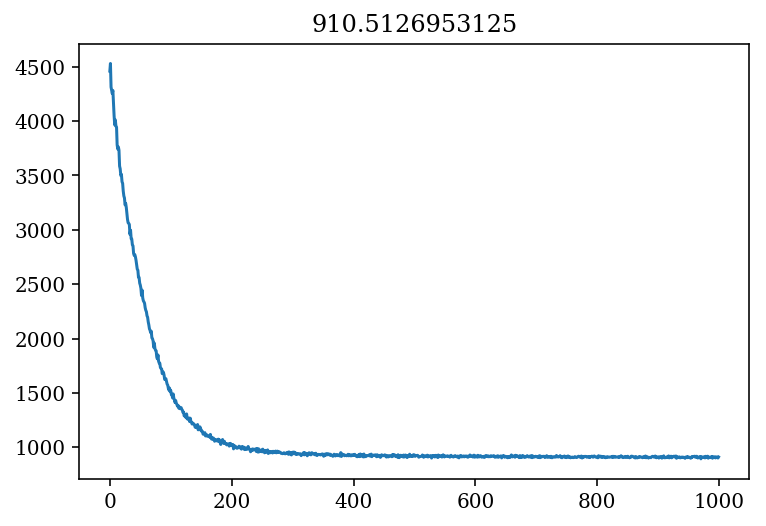

In [17]:
plt.plot(losses)
plt.title(str(losses[-1]))
plt.show()

In [19]:
test_binary(vsgp_xor,xor_test, xor_test_true, cuda=True)

91.0

In [14]:
xor_batch_loss = batch_train(vsgp_xor, True, X_xor, Y_xor, xor_test, xor_test_true,num_epochs=10)

Epoch 0 -- Accuracy = 87.0 -- Loss = 818.5360107421875
Epoch 1 -- Accuracy = 90.0 -- Loss = 229.4569854736328
Epoch 2 -- Accuracy = 91.0 -- Loss = 393.3885498046875
Epoch 3 -- Accuracy = 87.0 -- Loss = 552.1567993164062
Epoch 4 -- Accuracy = 88.0 -- Loss = 375.67498779296875
Epoch 5 -- Accuracy = 89.0 -- Loss = 126.95603942871094
Epoch 6 -- Accuracy = 90.0 -- Loss = 556.425537109375
Epoch 7 -- Accuracy = 78.0 -- Loss = 476.4971008300781
Epoch 8 -- Accuracy = 87.0 -- Loss = 360.21038818359375
Epoch 9 -- Accuracy = 92.0 -- Loss = 464.15252685546875


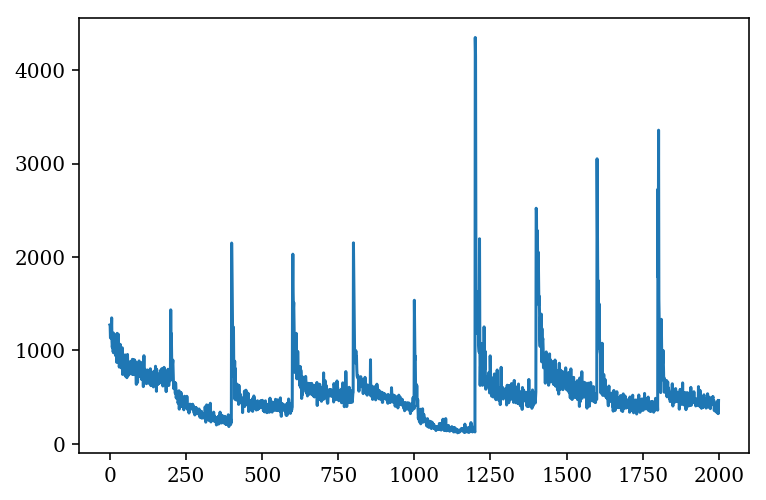

In [15]:
plt.plot(xor_batch_loss)
plt.show()

In [112]:
binary_pred = cuda_gpc.likelihood(f_loc, f_var).cpu()

In [113]:
binary_pred.eq(xor_test_true).detach().sum()*1./500.

tensor(0.9240)

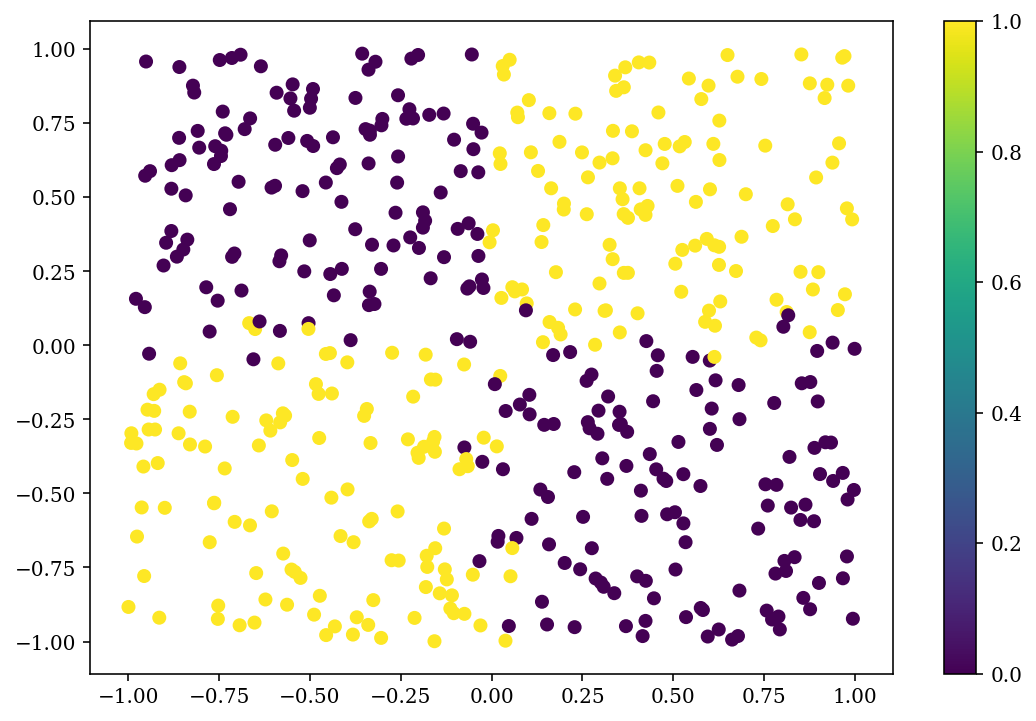

In [46]:
plt.scatter(xor_test_np[:,0],xor_test_np[:,1],c=binary_pred.detach().numpy())
plt.colorbar()
plt.show()

### GP Classificiation of the binarized digits dataset

As I understand the model is

$$ x_i \sim \N(0, \mathbb{I}) \ \ \ \ \ \ x_i \in \R^2$$
$$ f \sim \mathcal{GP}(0, RBF(x_i,x_j)) \ \ \ \ \ \ f: \R^2 \rightarrow \R^{64} $$
$$ y_i \sim \N(f(x_i), \sigma)$$
$$ z_i \sim Bernoulli(\Phi(y_i)) \ \ \ \ \ z_i \in \{0,1\}^{64} \ \  (\text{8x8 binary images}) $$

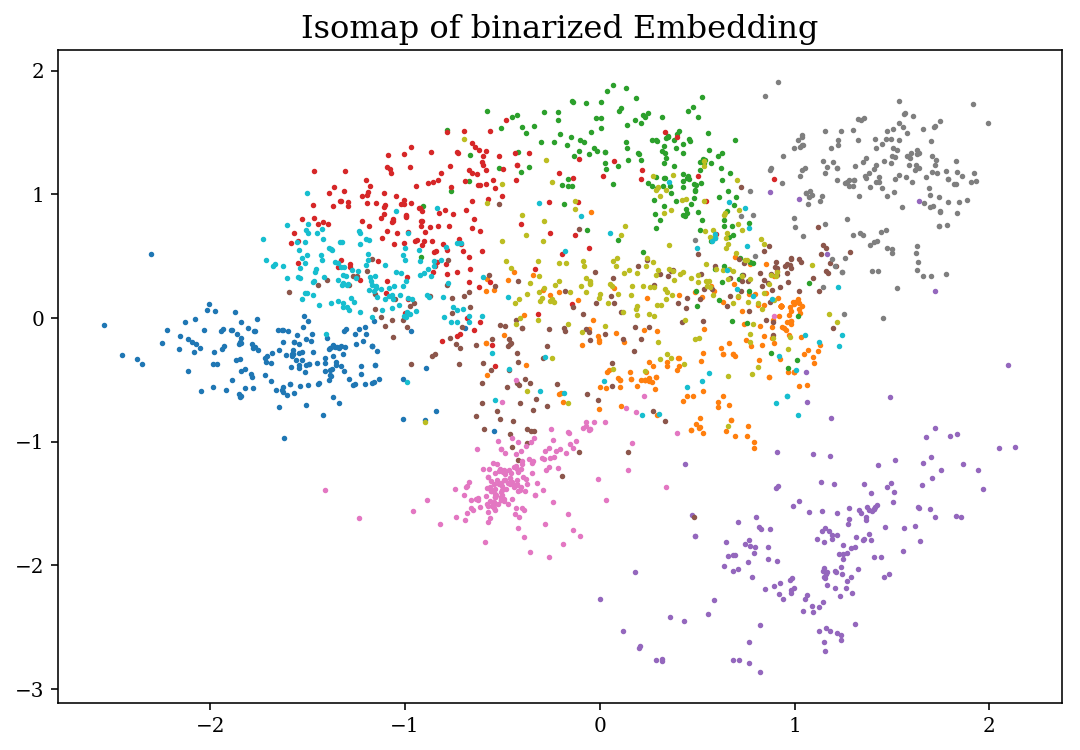

In [121]:
digits = datasets.load_digits()

ims = (digits.data>7).astype(np.float)
labels = digits.target
ims, labels = shuffle(ims, labels)

x_iso = Isomap().fit_transform(ims)
x_iso = (x_iso-x_iso.mean(axis=0))/x_iso.std(axis=0)

plot2dproj(x_iso,labels, "Isomap of binarized")

Astonishignly not bad?

In [38]:
#Set up training data
latent_dim=2
Y = torch.tensor(ims, dtype=torch.get_default_dtype())
X = torch.tensor(x_iso[:,:latent_dim],dtype=torch.get_default_dtype())
#X = Parameter(X_init.clone())
Y = torch.tensor(ims, dtype=torch.get_default_dtype())
cutoff = int(0.85*ims.shape[0])
X_train, X_test = X[:cutoff], X[cutoff:]
Y_train, Y_test = Y[:cutoff], Y[cutoff:]

In [39]:
#Set up kernel
rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
K = rbf
K = gp.kernels.Sum(K,m12)
K = gp.kernels.Sum(K,m32)
K = gp.kernels.Sum(K,m52)

#Set up likelihood
likelihood = gp.likelihoods.Binary()

#Set up inducing points by downsampling the training data
inds = torch.randperm(X_train.shape[0])
Xu = X_train[inds[:80]]
yu = Y_train[inds[:80]]

In [40]:
#Set up the model
gpc = gp.models.VariationalSparseGP(X=X_train, y=Y_train.t() ,kernel=K, Xu=Xu, likelihood=likelihood,
                                    jitter=1e-3, whiten=True, num_data = X_train.shape[0])
cuda_gpc = gpc.cuda()
cuda_gpc.X = cuda_gpc.X.cuda()
cuda_gpc.y = cuda_gpc.y.cuda()
#optimizer = torch.optim.Adam(cuda_gpc.parameters(), lr=0.01)
#loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss

In [41]:
opt = torch.optim.Adam(cuda_gpc.parameters(), lr=0.0025)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
n_steps = 2000
losses = []
bce = torch.nn.BCELoss(reduction='mean')
bce_losses = []
for i in range(n_steps):
        opt.zero_grad()
        loss = loss_fn(cuda_gpc.model, cuda_gpc.guide)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        # Show some output
        if (i+1)%100==0:
            with torch.no_grad():
                f_loc, f_var = cuda_gpc(X_test.cuda())
                probs = dist.Normal(f_loc, f_var)().sigmoid()
#                 print(probs.shape, Y_test.shape)
                bce_losses.append(torch.nn.BCELoss()(probs.t(),Y_test.cuda()))
            print(f'{i+1}: Accuracy = {test_binary(cuda_gpc,X_test,Y_test,True):0.5f} -- BCELoss = {bce_losses[-1]:0.5f}',end='\r')

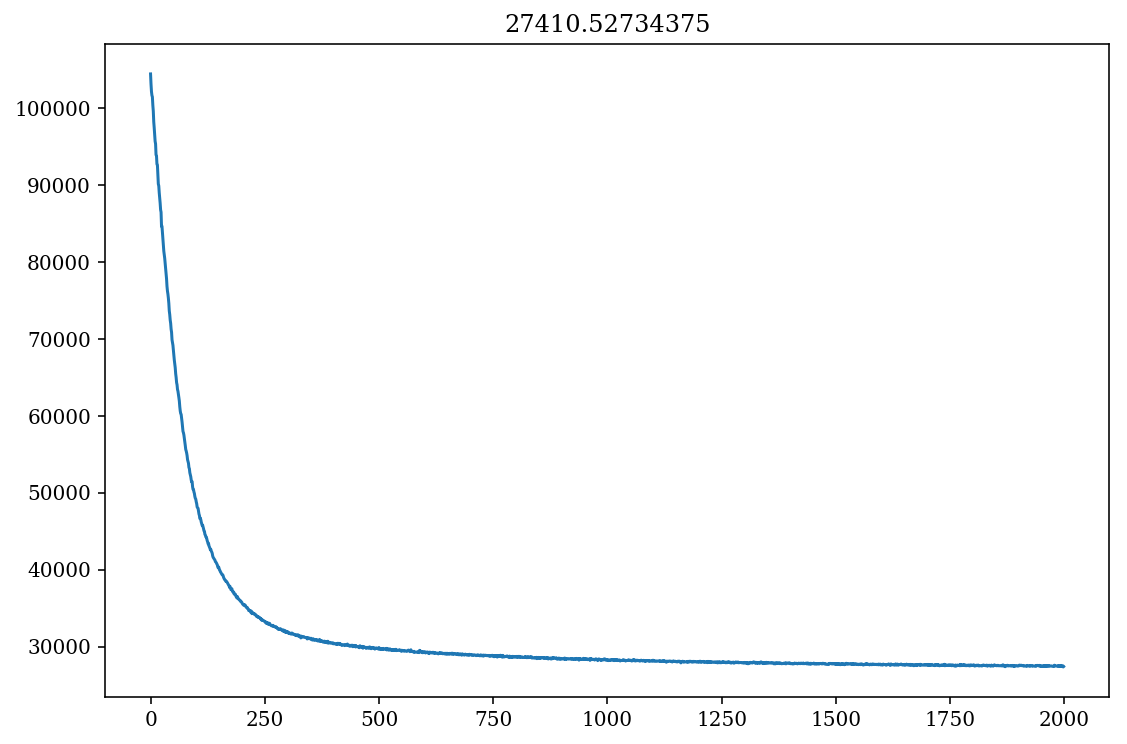

In [42]:
plt.plot(losses)
plt.title(losses[-1])
plt.show()

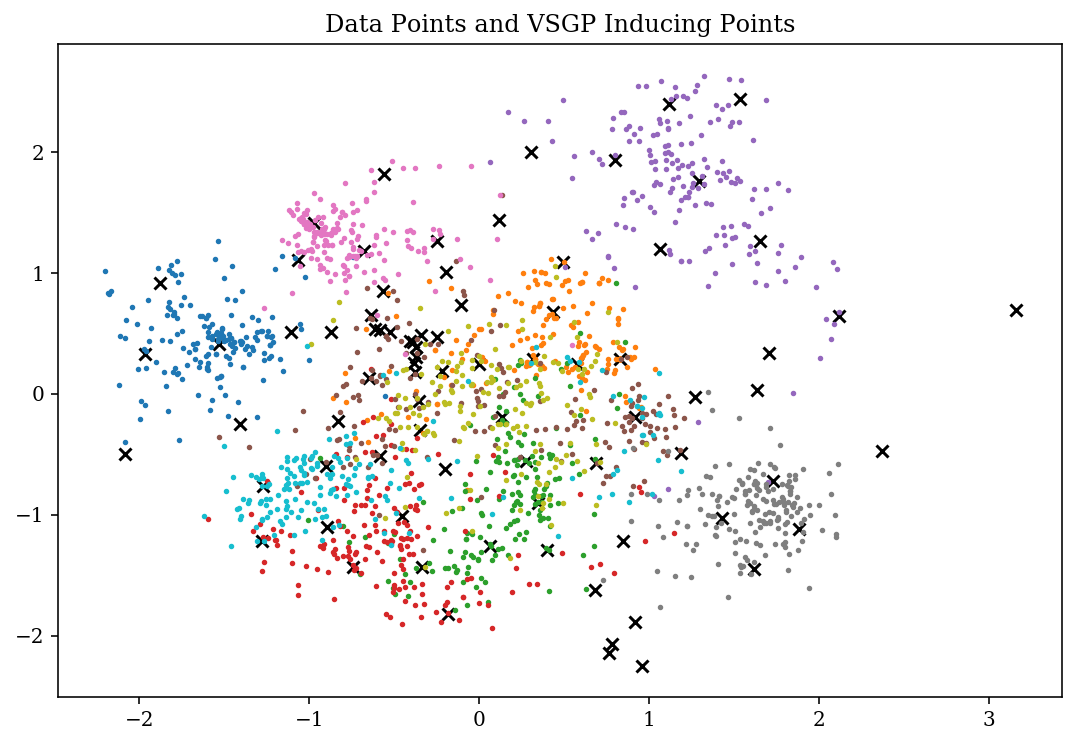

In [45]:
Xu_final = cuda_gpc.Xu.detach().cpu().numpy()
#plt.scatter(Xu.numpy()[:,0],Xu.numpy()[:,1],marker='*', color='k',label='init')
plt.scatter(Xu_final[:,0],Xu_final[:,1],marker='x', color='k', label='final')
#plt.scatter(cluster[:,0], cluster[:,1],marker='x', color='k', label='cluster?')
plt.title("Data Points and VSGP Inducing Points")
plot2dproj(x_iso,labels)

### Lets do CAT-GPLVM Now

In [122]:
#Set up training data
latent_dim=2
Y = torch.tensor(ims, dtype=torch.get_default_dtype())
X_init = torch.tensor(x_iso[:,:latent_dim],dtype=torch.get_default_dtype())
X = Parameter(X_init) #This line makes it a GPLVM
Y = torch.tensor(ims, dtype=torch.get_default_dtype())
# No testing data here, were just trying learn a good embedding
# cutoff = int(0.85*ims.shape[0])
X_train, X_test = X[:cutoff], X[cutoff:]
Y_train, Y_test = Y[:cutoff], Y[cutoff:]

In [123]:
#Set up kernel
rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X.max(0)[0] - X.mean(0))
K = rbf
K = gp.kernels.Sum(K,m12)
K = gp.kernels.Sum(K,m32)
K = gp.kernels.Sum(K,m52)

#Set up likelihood
likelihood = gp.likelihoods.Binary()

#Set up inducing points by downsampling the training data
inds = torch.randperm(X_train.shape[0])
Xu = X_train[inds[:80]]
yu = Y_train[inds[:80]]

In [124]:
#Set up the model
gplvm = gp.models.VariationalSparseGP(X=X, y=Y.t() ,kernel=K, Xu=Xu, likelihood=likelihood,
                                    jitter=1e-3, whiten=True, num_data = X.shape[0])
cuda_gplvm = gplvm.cuda()
#cuda_gplvm.X = cuda_gplvm.X.cuda()
cuda_gplvm.y = cuda_gplvm.y.cuda()
#optimizer = torch.optim.Adam(cuda_gpc.parameters(), lr=0.01)
#loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss

In [125]:
opt = torch.optim.Adam(cuda_gplvm.parameters(), lr=0.0025)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
n_steps = 2000
losses = []
bce = torch.nn.BCELoss(reduction='mean')
bce_losses = []
for i in range(n_steps):
        opt.zero_grad()
        loss = loss_fn(cuda_gplvm.model, cuda_gplvm.guide)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        # Show some output
        if (i+1)%100==0:
            with torch.no_grad():
                f_loc, f_var = cuda_gplvm(X_test.cuda())
                probs = dist.Normal(f_loc, f_var)().sigmoid()
#                 print(probs.shape, Y_test.shape)
                bce_losses.append(torch.nn.BCELoss()(probs.t(),Y_test.cuda()))
            print(f'{i+1}: Accuracy = {test_binary(cuda_gplvm,X_test,Y_test,True):0.5f} -- BCELoss = {bce_losses[-1]:0.5f}',end='\r')

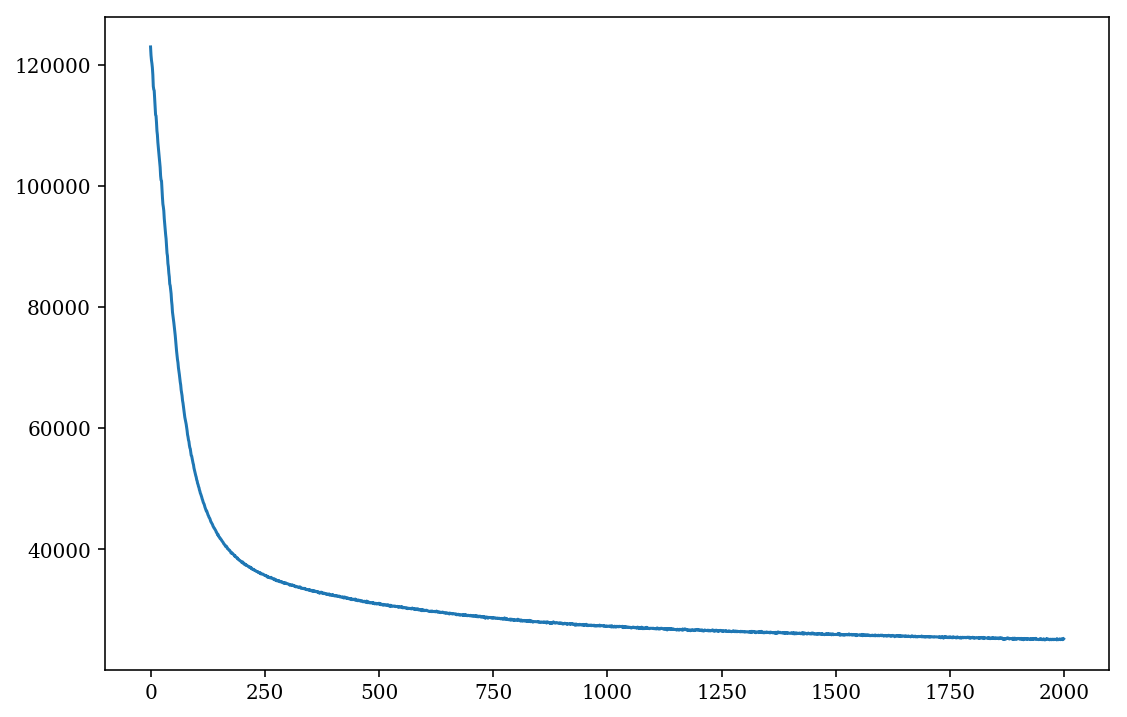

In [126]:
plt.plot(losses)
plt.show()

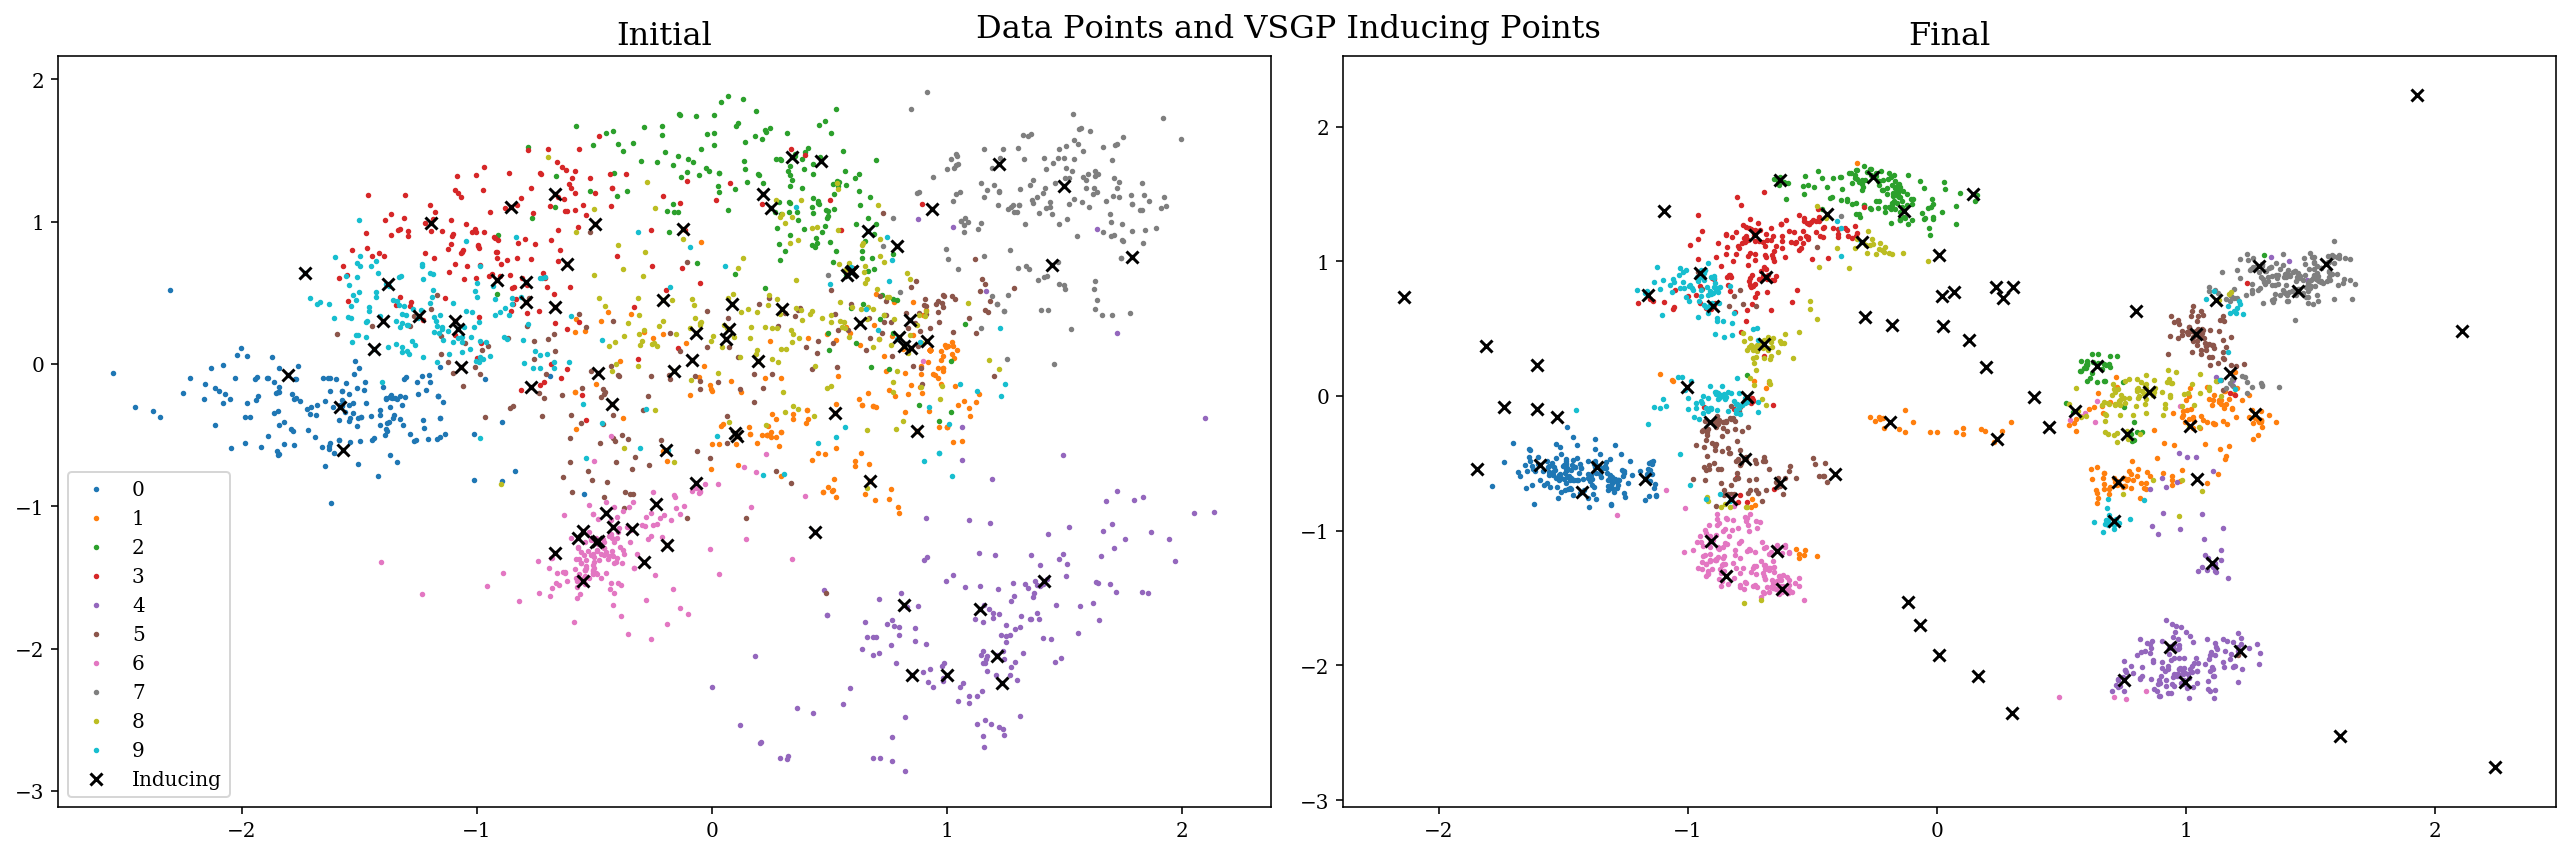

In [127]:
Xu_final = cuda_gplvm.Xu.detach().cpu().numpy()
X_final = cuda_gplvm.X.detach().cpu().numpy()

plot_before_after(X_init.detach().numpy(), X_final, Xu.detach().numpy(), Xu_final, labels, legend=True)
plt.tight_layout()
plt.savefig('cat_gplvm.png', dpi=200)
plt.show()

Im going to stop here but in general this was a good exercise. I'm feeling good about using pyro for all sorts of GPs applications and im less intimidated but the Variational (and or sparse) versions of things. This will be a good reference notebook for the training loops and helper functions. Also much easier that I thought it might be to deal with categorical variables on the back end. Using the discrete likelihoods was pretty easy. I'm going to spend a little time thinking about applying this to protein sequences for learning coevolution.

Potential revisit: Technically i dont think this a bayesian GPLVM since I dont set priors on the kernel lengthscales or the latent variables. The latent Xs is pretty easy with `gplvm.set_prior('X', dist.Normal(torch.zeros_like(X), 0.1)` the length scales are annoying because of how i compose them but what I think i need to do is set the prior on each kernel individually and then compose them and hope that the magic of pyro keeps things together.

### Batch Training Function for VSGPs

In [19]:
"""
So this is a moderately good thing, certainly for regression purposes, but the memory issues were from inverting
A massive kernel matrix so the *variational* sparse gp can be trained on the GPU no problem.
""" 
def batch_train(gpmodel, cuda, X_train, Y_train, X_test, Y_test, 
                loss_fn=pyro.infer.TraceMeanField_ELBO().differentiable_loss, optimizer=torch.optim.Adam, lr=0.01,
                num_epochs=20, num_steps=100, batch_size=100):
    opt = optimizer(gpmodel.parameters(), lr=lr)
    losses = [] 
    for e in range(num_epochs):
        # Set the batch
        batch_idx = torch.randperm(X_train.shape[0])[:batch_size]
        x_batch = X_train[batch_idx]
        y_batch = Y_train[batch_idx]
        if cuda: x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        gpmodel.set_data(x_batch, y_batch.t())
        #Take the steps
        for i in range(num_steps):
            opt.zero_grad()
            loss = loss_fn(gpmodel.model, gpmodel.guide)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        # Show some output
        print(f'Epoch {e} -- Accuracy = {test_binary(gpmodel,X_test,Y_test,cuda)} -- Loss = {losses[-1]}',end='\r')
    return losses

In [ ]:
batch_losses = batch_train(cuda_gpc, True, X_train, Y_train, X_test, Y_test)

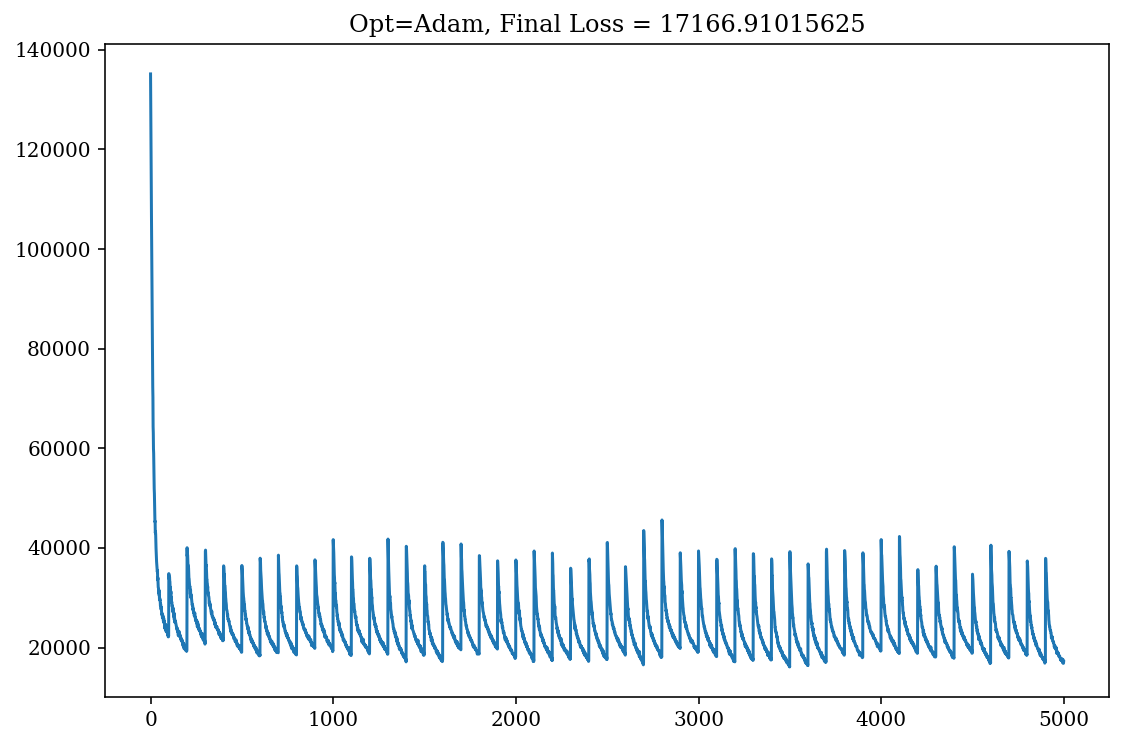

In [65]:
plt.plot(batch_losses)
plt.title(f'Opt=Adam, Final Loss = {str(batch_losses[-1])}')
#plt.savefig('adam_elbo.png')
plt.show()